## Initial Setup

In [1]:
%load_ext autoreload
%autoreload

## This expands a notebook to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))

## Show Python Version
import sys
print("Python: {0}".format(sys.version))

## Show Current Time
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Python: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Notebook Last Run Initiated: 2019-12-17 12:18:11.694446


## Import Useful Functions 

In [32]:
from pandas import DataFrame, Series, read_csv, to_numeric
from itertools import combinations
import networkx as nx
from pyvis import network as net

## Load User Friendly Functions

In [3]:
from ioUtilities import getFile, saveFile

# Network 101: Pokemon

In [76]:
## FYI, there are 18 Pokemon types each with weakness against at least one other type
weakAgainst = {}
weakAgainst["Ghost"] = ["Ghost", "Dark"]
weakAgainst["Dark"]  = ["Fighting", "Bug", "Fairy"]
weakAgainst["Fairy"] = ["Poison", "Steel"]
weakAgainst["Steel"] = ["Fire", "Fighting", "Ground"]
weakAgainst["Fire"]  = ["Water", "Ground", "Rock"]
weakAgainst["Rock"]  = ["Water", "Grass", "Fighting", "Ground", "Steel"]
weakAgainst["Grass"] = ["Fire", "Ice", "Poison", "Flying", "Bug"]
weakAgainst["Bug"]   = ["Fire", "Flying", "Rock"]
weakAgainst["Flying"] = ["Electric", "Ice", "Rock"]
weakAgainst["Electric"] = ["Ground"]
weakAgainst["Ground"] = ["Water", "Grass", "Ice"]
weakAgainst["Ice"]   = ["Fire", "Fighting", "Rock", "Steel"]
weakAgainst["Dragon"] = ["Ice", "Dragon", "Fairy"]
weakAgainst["Fairy"]  = ["Poison", "Steel"]
weakAgainst["Poison"] = ["Ground", "Psychic"]
weakAgainst["Psychic"] = ["Bug", "Ghost", "Dark"]
weakAgainst["Normal"] = ["Fighting"]
weakAgainst["Fighting"] = ["Flying", "Psychic", "Fairy"]
weakAgainst["Water"] = ["Electric", "Grass"]

color_map = {"Bug": "A8B820", "Dark": "705848", "Dragon": "7038F8", "Electric": "F8D030", "Fairy": "EE99AC",
             "Fighting": "C03028", "Fire": 'FF0000', "Flying": "A890F0", "Ghost": "705898", "Grass": "78C850",
             "Ground": 'B5651D', "Ice": "98D8D8", "Normal": "A8A878", "Poison": "A040A0", "Psychic": "F85888",
             "Rock": "B8A038", "Steel": "B8B8D0", "Water": "6890F0"}

## Create a Directed (Di) Graph

In [105]:
G = nx.DiGraph()
#G = nx.MultiDiGraph()

## Build Network By Adding Edges (i.e., Water is weak against Electric and Grass types)

In [106]:
for ptype,vals in weakAgainst.items():
    for val in vals:
        G.add_edge(val, ptype, color="#{0}".format(color_map[val]))

## Draw Network

In [107]:
labels = list(G.nodes())
node_colors = ["#{0}".format(color_map[node]) for node in G.nodes()]
nodes = G.nodes(True)
node_labels = {n: n for n, attrs in nodes}

In [109]:
edges = G.edges()
edge_colors = [G[u][v]['color'] for u,v in edges]

In [110]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 12)

Drawing the self-loops is a pain so we're skipping that part


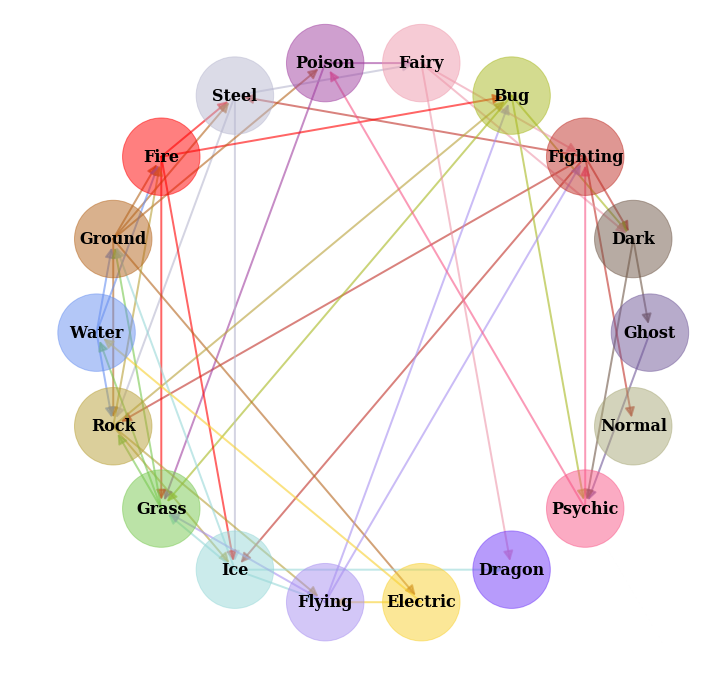

In [116]:
print("Drawing the self-loops is a pain so we're skipping that part")
pos = nx.circular_layout(G)
#pos = nx.spring_layout(G)
#pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=6000, node_shape='o', node_color=node_colors, alpha=0.5)
nx.draw_networkx_edges(G, pos, style='dotted', arrowsize=20, edge_color=edge_colors, width=2, alpha=0.6)
nx.draw_networkx_labels(G, pos, node_labels, alpha=1, font_size=16, font_weight='bold', font_family='serif')
plt.axis('off')
plt.savefig("types.pdf", dpi=150) ## Plot is saved as a PDF

## Load IMDB Actor/Movie Data

In [4]:
## getFile will load the pickle file (ext-->.p)
networkDF = getFile("data.p")

In [7]:
## Show the first 5 rows of the dataframe
networkDF.head()

,Title,Actor,Year,Award,Key
3,Valdemar Sejr,Peter Malberg,1910,NaN,Valdemar Sejr 1910
4,Valdemar Sejr,Ellen Gottschalch,1910,NaN,Valdemar Sejr 1910
7,Ekspeditricen,Clara Pontoppidan,1911,NaN,Ekspeditricen 1911
8,Ekspeditricen,Thorkild Roose,1911,NaN,Ekspeditricen 1911
11,Par habitude,Maurice Chevalier,1911,NaN,Par habitude 1911


## Add a few useful columns to the data frame

In [6]:
## Make year a string
networkDF[networkDF['Year'].apply(lambda x: isinstance(x, str))]
## Create unique key
networkDF["Key"] = networkDF[["Title", "Year"]].apply(lambda x: " ".join([str(y) for y in x]), axis=1)

In [8]:
## Show the first 5 rows of the dataframe
networkDF.head()

,Title,Actor,Year,Award,Key
3,Valdemar Sejr,Peter Malberg,1910,NaN,Valdemar Sejr 1910
4,Valdemar Sejr,Ellen Gottschalch,1910,NaN,Valdemar Sejr 1910
7,Ekspeditricen,Clara Pontoppidan,1911,NaN,Ekspeditricen 1911
8,Ekspeditricen,Thorkild Roose,1911,NaN,Ekspeditricen 1911
11,Par habitude,Maurice Chevalier,1911,NaN,Par habitude 1911


## Create an Actor Network

In [15]:
## Create networkx graph object
nxG = nx.Graph()

print("Full Network Size:   ",networkDF.shape)

## Limit network to movies that have at least one award and made in the last decade
limNetworkDF = networkDF[(networkDF['Award'] < 10) & (networkDF["Year"] > 2010)].copy()
print("Limited Network Size:",limNetworkDF.shape)
for movie, df in limNetworkDF.groupby('Key'):
    people  = df["Actor"].tolist()
    mapping = list(combinations(people, 2))
    nxG.add_edges_from(mapping, label=movie)
print("Number of Nodes: {0}".format(len(nxG.nodes())))
print("Number of Edges: {0}".format(len(nxG.edges())))

Full Network Size:    (132236, 5)
Limited Network Size: (4333, 5)
Number of Nodes: 2847
Number of Edges: 6375


## Draw limited network 

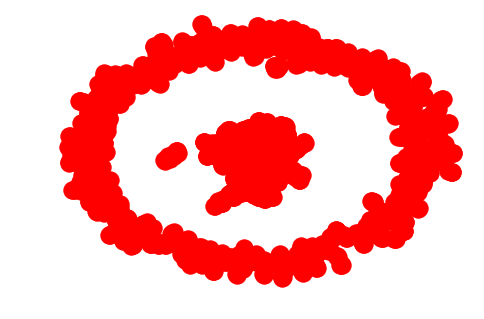

In [18]:
## Try Spring Layout (this will take a little bit of time)
pos = nx.spring_layout(nxG)
nx.draw(nxG, pos)

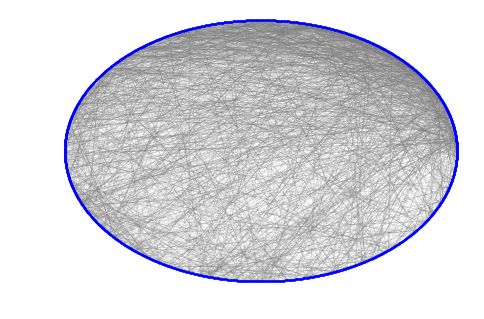

In [27]:
## Try Circular Layout (should be fast)
pos = nx.circular_layout(nxG)
nx.draw(nxG, pos, node_size=1, node_color='blue', width=0.1, edge_color='grey')

In [30]:
## Try KK Layout (will take a long time)
pos = nx.kamada_kawai_layout(nxG)
nx.draw(nxG, pos, node_size=1, node_color='blue', width=0.1, edge_color='grey')

# AP Network Graphs

In [ ]:
def createNetwork(pyG, name):
    from pyvis import network as net
    #Network(, bgcolor="#222222", font_color="white")
    #pyG.from_nx(g)

    #neighbor_map = pyG.get_adj_list()
    #s = Series([len(x) for x in neighbor_map])
    from numpy import log1p, tanh
    #degrees      = g.degree()
    for node in pyG.nodes:
        #node["label"]  = name["id"]
        node["title"] = "{0}<br>".format(node['label'])
        #node["title"] += " Degree   :{0}<br>".format(degrees[node['id']])
        #node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
        #node["value"] = log1p(len(neighbor_map[node["id"]]))/10.0
        node["shape"] = "dot"
        node["mass"]  = node["size"]/10

#        ,
#          "color": {
#            "background": "rgba(108,247,252,1)",
#            "highlight": {
#              "border": "rgba(76,99,229,0.87)",
#              "background": "rgba(255,75,206,1)"
#            }
          
    pyG.show_buttons(filter_=['physics'])
    options = """var options = {
        "configure": {
            "enabled": true
        },
        "edges": {
            "color": {
                "inherit": true
            },
            "width": 0.2,
            "smooth": {
                "enabled": false,
                "type": "continuous"
            }
        },
        "interaction": {
            "dragNodes": false,
            "hideEdgesOnDrag": false,
            "hideNodesOnDrag": false
        },
        "physics": {
            "barnesHut": {
                  "gravitationalConstant": -23300,
                  "springConstant": 0.005
            },
            "maxVelocity": 37,
            "minVelocity": 0.75,
            "enabled": true,
            "stabilization": {
                "enabled": true,
                "fit": true,
                "iterations": 1000,
                "onlyDynamicEdges": false,
                "updateInterval": 50
            }
        }
    }"""
    pyG.set_options(options)
    pyG.show("{0}.html".format(name))
    print("Wrote {0}".format("{0}.html".format(name)))

# Build Network From One Actor To Another

In [70]:
source = "Kevin Bacon"
target = "Meryl Streep"

In [71]:
## Maximum number of connections between source and target
cutoff = 2

In [72]:
nxGraph = nx.Graph()
pyG  = net.Network(height="850px", width="70%")
unique = {}



size_lookup   = {2: 50, 3: 30, 4: 15, 5: 10, 6: 5}
width_lookup  = {1: 20, 2: 10, 3: 5, 4: 1, 5: 0.5, 6: 0.25}
color_lookup  = {2: '#000000', 3: '#0066FF', 4: "#98FB98", 5: "#FFB6C1", 5: "#FFB6C1", 6: "#ADD8E6"}

node_attrs  = {source: {"Path": 2, "Color": color_lookup[2], "Size": size_lookup[2]},
               target: {"Path": 2, "Color": color_lookup[2], "Size": size_lookup[2]}}
edge_attrs  = {}



## The all_simple_paths function is the key here
for path in nx.all_simple_paths(nxG, source, target, cutoff=cutoff):
    #print(path)
    
    for i in range(len(path)-1):
        edge = (path[i],path[i+1])
        label = nxG[path[i]][path[i+1]]["label"]
        nxGraph.add_edge(edge[0], edge[1])
        
        for node in edge:
            if node_attrs.get(node) is not None:
                if len(path) >= node_attrs[node]["Path"]:
                    continue
            node_attrs[node] = {"Path": len(path), "Color": color_lookup[len(path)], "Size": size_lookup[len(path)]}
            #print("==>",len(path),node,node_attrs[node])
        
        if edge_attrs.get(edge) is not None:
            if len(path) >= edge_attrs[edge]["Path"]:
                continue
        #print(path)
        edge_attrs[edge] = {"Path": len(path), "Color": color_lookup[len(path)], "Label": label, "Width": width_lookup[len(path)-1]}
        #print("-->",len(path),edge,edge_attrs[edge])

nx.set_node_attributes(nxGraph, node_attrs)
nx.set_edge_attributes(nxGraph, edge_attrs)
if False:
    print("")
    for k,v in node_attrs.items():
        print(k,v)
#print(nxGraph.nodes(data=True))
print("Network of {0} and {1}".format(source, target))
print("Number of Nodes: {0}".format(len(nxGraph.nodes())))
print("Number of Edges: {0}".format(len(nxGraph.edges())))

Network of Kevin Bacon and Meryl Streep
Number of Nodes: 14
Number of Edges: 25


In [73]:
## Some useful values to keep the plots pretty
node_lookup = dict(zip(range(len(node_attrs)), node_attrs.keys()))
edge_lookup = dict(zip(node_attrs.keys(), range(len(node_attrs))))
node_size   = [x["Size"] for x in node_attrs.values()]
node_color  = [x["Color"] for x in node_attrs.values()]

print(len(node_lookup))
print(len(edge_lookup))
print(len(node_size))
print(len(node_color))

14
14
14
14


In [74]:
pyG  = net.Network(height="850px", width="70%")
pyG.add_nodes(nodes=range(len(node_lookup)), label=list(node_lookup.values()), size=node_size, color=node_color)
for edge in nxGraph.edges(data=True):
    pyG.add_edge(edge_lookup[edge[0]], edge_lookup[edge[1]], title=edge[2]["Label"], color=edge[2]["Color"], weight=edge[2]["Width"])

In [75]:
createNetwork(pyG, "_".join([source,target]))

Wrote Kevin Bacon_Meryl Streep.html
